import clasic libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from matplotlib import colors


import python scripts and imporlib

In [6]:
import importlib
import py_scripts  # python scripts

import files, functions, classes

In [12]:
from py_scripts.upscale_matrix import upscale_matrix


define upscale matrix

In [13]:
# Example usage of upscale_matrix

#upscale_matrix(2, 3) -> 3x3 matrix of 2s
matrix = np.array([[1, 2], [3, 4]])
matrix_upscaled = upscale_matrix(matrix, 2)
print("Upscaled Matrix:\n", matrix_upscaled)


Upscaled Matrix:
 [[1 1 2 2]
 [1 1 2 2]
 [3 3 4 4]
 [3 3 4 4]]


theory

In [3]:
"""
# Tissue matrix representing tumor and healthy cells
- 0 = healthy cell
- 1 = tumor cell
"""

"""
Lets explain in more detail how we will use linear programming to solve this problem:
1. We are irradiatin tissue matrix with radiation beams. 
2. Tissue shape is (at least for now) rectangular matrix with rows and columns - (Nrows, Ncols).
3. Beams are narrow ("pencil-like") and can be placed along rows and columns of the matrix.
4. Each beam will irradiate all cells in its row and column - and nothing else (no scatter ect).
5. Beams in our first example are placed only left from and above the tumor cells - so we have Nrows + Ncols beams. 
5. We will use linear programming to optimize the beam intensities such that:
    - tumor cells receive at least a minimum dose of radiation (MinDoseTumorCells) 
    - healthy cells receive no more than a maximum dose of radiation (MaxDoseHealthyCells)
6. The objective function will minimize the total dose to healthy cells, which is represented by the cost function coefficients (c vector).
7. The constraints will ensure that tumor cells receive the required minimum dose and healthy cells do not exceed the maximum dose.
8. We are searching for beam intensities that satisfy these conditions, lets denote them as BeamIntensities.
9. BeamIntensities will be a vector of length Nrows + Ncols, where each element represents the intensity of a beam.
10. The solution will provide the optimal beam intensities that satisfy these conditions.
"""




'\nLets explain in more detail how we will use linear programming to solve this problem:\n1. We are irradiatin tissue matrix with radiation beams. \n2. Tissue shape is (at least for now) rectangular matrix with rows and columns - (Nrows, Ncols).\n3. Beams are narrow ("pencil-like") and can be placed along rows and columns of the matrix.\n4. Each beam will irradiate all cells in its row and column - and nothing else (no scatter ect).\n5. Beams in our first example are placed only left from and above the tumor cells - so we have Nrows + Ncols beams. \n5. We will use linear programming to optimize the beam intensities such that:\n    - tumor cells receive at least a minimum dose of radiation (MinDoseTumorCells) \n    - healthy cells receive no more than a maximum dose of radiation (MaxDoseHealthyCells)\n6. The objective function will minimize the total dose to healthy cells, which is represented by the cost function coefficients (c vector).\n7. The constraints will ensure that tumor cells

---

Intermezzo:
 - the system seems to be much underdetermined
 - there are 4N beams = parameters
 - for them, only as many equations as there are tumor cells, unless we add aditional conditions
 - if N_tumor < 4N, --> underdetermined system
 -
 [[Was talking to ChatGPT and it pointed out this, so something big to consider]]

--------------
----------------


In [6]:
# import npy file from the folder
SIF_expanded = np.load('SIF_expanded.npy')
### SIF = Simulation Irradioation Factors

Class TissueIrradiation

In [ ]:
class TissueIrradiationProblem:
    def __init__(self, tissue_matrix): 
    #! Thing to consider - where to initialize variables: at class instance initializaton or at method begining? #######
        self.tissue_matrix = np.array(tissue_matrix)
        self.nrows, self.ncols = self.tissue_matrix.shape
        self.ncells = self.nrows * self.ncols
        self._analyze_tissue()
        
    def plot_tissue(self):
        cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        plt.imshow(self.tissue_matrix, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
        plt.title('Tkivo')
        ax = plt.gca()
        # Set minor ticks at cell edges
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        # Draw gridlines at minor ticks
        ax.grid(which='minor', color='red', linestyle='-', linewidth=1)
        # Make sure ticks are not shown
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.show()

    def _analyze_tissue(self):
        self.tumor_positions = np.argwhere(self.tissue_matrix == 1)
        self.healthy_positions = np.argwhere(self.tissue_matrix == 0)
        self.n_tumor = len(self.tumor_positions)
        self.n_healthy = len(self.healthy_positions)
        self.n_beams = 2 * (self.nrows + self.ncols)

    def prepare_data_for_linprog(self,cell_dose_constr,beam_type='constant', lac=1.0,sim_irr_factors=None):
        """
        Prepare the data for linear programming optimization.
        This method creates the necessary matrices and vectors for the optimization problem.
        """
        self.beam_type = beam_type
        self.lac = lac
        self.simulation_irradiation_factors = sim_irr_factors
        self.cell_dose_constr = cell_dose_constr  
        self.min_dose_tumor = cell_dose_constr['min_dose_tumor']
        self.max_dose_healthy = cell_dose_constr.get('max_dose_healthy', None) # this one is optional
        
        #* run methods to prepare data for linear programming
        self.create_dose_distribution_matrix()
        self.define_linprog_inputs()
        self.define_linprog_inputs()

        return {
            "c_beams": self.c_beams,
            "A_ub": self.A_ub,
            "b_ub": self.b_ub,
            "A_eq": self.A_eq,
            "b_eq": self.b_eq,
            "A_tissue": self.A_tissue,
            "A_tumor": self.A_tumor,
            "A_healthy": self.A_healthy,
            "nrows": self.nrows,
            "ncols": self.ncols,
            "nbeams": self.n_beams,
            "ncells": self.ncells,
            "beam_type": self.beam_type,
            "tissue_matrix": self.tissue_matrix,
            "beam_type": self.beam_type,
            "lac": self.lac,
            # "simulation_irradiation_factors": self.simulation_irradiation_factors,
            # "min_dose_tumor": self.min_dose_tumor,
            # "max_dose_healthy": self.max_dose_healthy,
            # "delta_kij": self.delta_kij,
            # "n_tumor": self.n_tumor,
            # "n_healthy": self.n_healthy,
            # "tumor_positions": self.tumor_positions,
            # "healthy_positions": self.healthy_positions,

        }
    
    def create_dose_distribution_matrix(self):
        """
        Create the 3D dose distribution matrix (delta_kij) for the tissue matrix.
        Uses N_rows and N_cols from the notebook variables if available.
        Returns a numpy array of shape (N_beams, N_rows, N_cols).
        """
        # Use N_rows and N_cols from notebook if available, else from self
        nrows = self.nrows
        ncols = self.ncols
        n_beams = self.n_beams
        delta_kij = np.zeros((n_beams, nrows, ncols), dtype=float)

        # Fill delta_kij for all beams in a single loop, separating beam_type only once
        if self.beam_type == 'constant':
            print("Using constant intensity beam model.")
            # Left beams (rows)
            for i in range(nrows):
                for j in range(ncols):
                    delta_kij[i, i, j] = 1.0
            # Right beams (rows)
            for i in range(nrows):
                for j in range(ncols):
                    delta_kij[nrows + i, i, j] = 1.0
            # Top beams (cols)
            for j in range(ncols):
                for i in range(nrows):
                    delta_kij[2 * nrows + j, i, j] = 1.0
            # Bottom beams (cols)
            for j in range(ncols):
                for i in range(nrows):
                    delta_kij[2 * nrows + ncols + j, i, j] = 1.0
        
        elif self.beam_type == 'exponential':
            print("Using exponential intensity beam model with linear attenuation coefficient (lac):", self.lac, "/cm")
            lac = self.lac
            # Left beams (rows)
            for i in range(nrows):
                for j in range(ncols):
                    delta_kij[i, i, j] = np.exp(-lac * j)
            # Right beams (rows)
            for i in range(nrows):
                for j in range(ncols):
                    delta_kij[nrows + i, i, j] = np.exp(-lac * (ncols - j - 1))
            # Top beams (cols)
            for j in range(ncols):
                for i in range(nrows):
                    delta_kij[2 * nrows + j, i, j] = np.exp(-lac * i)
            # Bottom beams (cols)
            for j in range(ncols):
                for i in range(nrows):
                    delta_kij[2 * nrows + ncols + j, i, j] = np.exp(-lac * (nrows - i - 1))
        
        elif self.beam_type == 'simulated':
            print("Using beam from self simulated data for energy deposition distribution.")
            # Simulated beams logic would go here, similar to the above but using simulated data
            # For now, we will just fill with zeros as a placeholder
            if self.simulation_irradiation_factors is None:
                raise ValueError("Simulation_irradiation_factors must be provided for 'simulated' beam type.")
            delta_kij = self.simulation_irradiation_factors

        elif self.beam_type in ['proton', 'neutron', 'electron', 'other_stuff']:
            raise NotImplementedError(f"Beam type '{self.beam_type}' is not implemented yet.")
        else:
            raise ValueError(f"Unknown beam_type: {self.beam_type}")

        # at the end, make delta_kij factors matrix an attribute
        self.delta_kij = delta_kij

    def define_linprog_inputs(self):
        self.c_beams = np.zeros(self.n_beams, dtype=float)
        self.A_tissue = np.zeros((self.ncells, self.n_beams))
        self.A_tumor = []
        self.A_healthy = []
        self.A_eq = None
        self.b_eq = None

        # define c_beams
        for i in range(self.n_beams):
            self.c_beams[i] = np.sum(self.delta_kij[i, self.tissue_matrix == 0])  # Sum over healthy cells for constant beam
        # define A_tissue
        for idx in range(self.ncells):
            i = idx // self.ncols
            j = idx % self.ncols
            row = np.zeros(self.n_beams, dtype=float)
            for k in range(self.n_beams):
                row[k] = self.delta_kij[k, i, j]
            self.A_tissue[idx] = row
            if self.tissue_matrix[i, j] == 1:
                self.A_tumor.append(row)
            else:
                self.A_healthy.append(row)
        
        #* define A_eq and b_eq if constant beam type - because we cancel beams from the right and bottom
        if self.beam_type == 'constant':
            # add A_eq for dead beams (set right and bottom beams to zero)
            dead_beams_matrix = np.zeros((self.nrows + self.ncols, self.n_beams), dtype=int)
            for i in range(self.nrows):
                dead_beams_matrix[i, self.nrows + i] = 1  # right beams
            for j in range(self.ncols):
                dead_beams_matrix[self.nrows + j, 2 * self.nrows + self.ncols + j] = 1  # bottom beams
            self.A_eq = dead_beams_matrix
            self.b_eq = np.zeros(self.nrows + self.ncols)

        self.A_tumor = np.array(self.A_tumor)
        self.A_healthy = np.array(self.A_healthy)
        
        #* define A_upper_bound - just A_tumor and b_ub, but both with minus as we minimize!
        self.A_ub = -np.array(self.A_tumor)  # MINUS!!!
        self.b_ub = -np.ones(self.n_tumor) * self.min_dose_tumor  # MINUS!!!
        
        #* add A_healthy and extend b_ub if max dose to H cells is prescribed
        if self.max_dose_healthy is not None:
            self.A_ub = np.vstack((self.A_ub, self.A_healthy))
            self.b_ub = np.concatenate((self.b_ub, np.ones(self.n_healthy) * self.max_dose_healthy))
            


In [ ]:
class TissueIrradiationOptimizer:
    def __init__(self, problem_parameters):
        self.problem_parameters = problem_parameters
        self.optimized = False

        # extract parameters from problem_parameters
        # fixme: this could be inherited from TissueIrradiationProblem class; explore!
        self.nrows = problem_parameters["nrows"]
        self.ncols = problem_parameters["ncols"]
        self.ncells = self.nrows * self.ncols
        self.nbeams = 2 * (self.nrows + self.ncols)
        self.tissue_matrix = problem_parameters["tissue_matrix"]
        self.c_beams = problem_parameters["c_beams"]
        self.A_tissue = problem_parameters.get("A_tissue", None)
        self.A_tumor = problem_parameters.get("A_tumor", None)
        self.A_healthy = problem_parameters.get("A_healthy", None)
        self.A_ub = problem_parameters["A_ub"]
        self.b_ub = problem_parameters["b_ub"]
        self.A_eq = problem_parameters.get("A_eq", None)
        self.b_eq = problem_parameters.get("b_eq", None)
        self.beam_type = problem_parameters["beam_type"]
        self.lac = problem_parameters.get("lac", 1.0)

        #self.optimal_beam_intensities = None
        self.optimal_beam_intensities = np.zeros(self.nbeams)  # Initialize with zeros
        self.DH_tot = -99

    def optimize(self, doReport=False):        
        self.result = linprog(c=self.c_beams, A_ub=self.A_ub, b_ub=self.b_ub, method='highs',A_eq=self.A_eq, b_eq=self.b_eq)

        if self.result.success:
            self.optimal_beam_intensities = self.result.x
            self.DH_tot = self.result.fun
            self.optimized = True
            if doReport:
                print("Optimization successful.")
                print("Optimal value:", self.result.fun)
                print("Optimal solution:", self.result.x)
            # calculate dose distribution
            self.calculate_dose_distribution()
        else:
            print("Optimization failed:", self.result.message)

    def calculate_dose_distribution(self):
        if not self.optimized:
            print("Run optimize() first.")
            return
        self.tissue_dose_matrix = self.A_tissue @ self.optimal_beam_intensities.reshape(-1, 1) # reshape: make a column out of line
        self.tissue_dose_matrix = self.tissue_dose_matrix.reshape(self.nrows, self.ncols) # reshape to tissue matrix shape

    def plot_dose_distribution(self):
        if not self.optimized:
            print("Run optimize() first.")
            return

        fig, ax = plt.subplots(figsize=(4, 4))
        cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        im = ax.imshow(self.tissue_dose_matrix, cmap=cmap, interpolation='nearest', 
                       vmin=np.min(self.tissue_dose_matrix), vmax=np.max(self.tissue_dose_matrix),
                       extent=[-0.5, self.ncols-0.5, self.nrows-0.5, -0.5])

        # Draw grid lines for cells (only at cell boundaries)
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_xlim(-0.5, self.ncols-0.5)
        ax.set_ylim(self.nrows-0.5, -0.5)

        # Annotate each cell with its dose (if nonzero)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose = self.tissue_dose_matrix[i, j]
                if dose > 0:
                    ax.text(j, i, f"{dose:.0f}", ha='center', va='center', color='red', fontsize=12, fontweight='bold')

        # Highlight tumor cells with red edges
        tumor_mask = (self.tissue_matrix == 1)
        for (i, j) in np.argwhere(tumor_mask):
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

        plt.title('Porazdelitev doze po tkivu')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

    def plot_irradiation_scheme(self):
        if not self.optimized:
            print("Run optimize() first.")
            return

        fig, ax = plt.subplots(figsize=(6, 6))
        cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        im = ax.imshow(self.tissue_dose_matrix, cmap=cmap, interpolation='nearest', 
                       vmin=np.min(self.tissue_dose_matrix), vmax=np.max(self.tissue_dose_matrix),
                       extent=[-0.5, self.ncols-0.5, self.nrows-0.5, -0.5])

        # Draw grid lines for cells (only at cell boundaries)
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_xlim(-0.5, self.ncols-0.5)
        ax.set_ylim(self.nrows-0.5, -0.5)

        # Annotate each cell with its dose (if nonzero)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose = self.tissue_dose_matrix[i, j]
                if dose > 0:
                    ax.text(j, i, f"{dose:.0f}", ha='center', va='center', color='red', fontsize=12, fontweight='bold')

        # Highlight tumor cells with red edges
        tumor_mask = (self.tissue_matrix == 1)
        for (i, j) in np.argwhere(tumor_mask):
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=4, edgecolor='darkred', facecolor='none')
            ax.add_patch(rect)

        # Highlight tissue edges
        ax.plot([-0.5, self.ncols-0.5], [-0.5, -0.5], color='black', linewidth=2)
        ax.plot([-0.5, self.ncols-0.5], [self.nrows-0.5, self.nrows-0.5], color='black', linewidth=2)
        ax.plot([-0.5, -0.5], [-0.5, self.nrows-0.5], color='black', linewidth=2)
        ax.plot([self.ncols-0.5, self.ncols-0.5], [-0.5, self.nrows-0.5], color='black', linewidth=2)
        
        # Draw beams: horizontal (rows) and vertical (cols) with smaller arrows at the edges
        arrow_length = 0.7
        arrow_head_width = 0.12
        arrow_head_length = 0.12
        ## beam intensities from left and right directions
        for beam_idx in range(self.nrows):
            intensity_left = self.optimal_beam_intensities[beam_idx]
            intensity_right = self.optimal_beam_intensities[self.nrows + beam_idx]
            if intensity_left > 0:
                # Left edge arrow for row beams
                ax.arrow(-0.9, beam_idx, arrow_length, 0, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='blue', ec='blue', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(-0.9, beam_idx, f"{intensity_left:.0f}", va='center', ha='right', color='blue', fontsize=11)
            if intensity_right > 0:
                # Right edge arrow for row beams
                ax.arrow(self.ncols-0.2, beam_idx, -arrow_length, 0, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='blue', ec='blue', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(self.ncols-0.3, beam_idx, f"{intensity_right:.0f}", va='center', ha='left', color='blue', fontsize=11)
        
        # intensities from top and bottom directions
        for beam_idx in range(self.ncols):
            intensity_top = self.optimal_beam_intensities[2*self.nrows + beam_idx]
            intensity_bottom = self.optimal_beam_intensities[2*self.nrows + self.ncols + beam_idx]
            if intensity_top > 0:
                # Top edge arrow for column beams
                ax.arrow(beam_idx, -0.9, 0, arrow_length, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='green', ec='green', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(beam_idx, -0.7, f"{intensity_top:.0f}", va='bottom', ha='center', color='green', fontsize=11)
            if intensity_bottom > 0:
                # Bottom edge arrow for column beams
                ax.arrow(beam_idx, self.nrows-0.3, 0, arrow_length, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='green', ec='green', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(beam_idx, self.nrows-0.3, f"{intensity_bottom:.0f}", va='top', ha='center', color='green', fontsize=11)

        if self.beam_type == 'constant':
            beam_type_message = "konstantna intenziteta"
        elif self.beam_type == 'exponential':
            lambda_sign = 'λ'
            beam_type_message = f"eksponentna intenziteta ({lambda_sign}={1/self.lac} celica)"
        elif self.beam_type == 'simulated':
            beam_type_message = "simulirana intenziteta"
        plt.title(f'Obsevalni načrt in dozna porazdelitev\n{beam_type_message}')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

    def report_statistics(self):
        print("Statistics:")
        if not hasattr(self, 'tissue_dose_matrix'): 
            print("Run calculate_dose_distribution() first.")
            return  
        tumor_mask = (self.tissue_matrix == 1)
        healthy_mask = (self.tissue_matrix == 0)
        avg_dose_tumor = self.tissue_dose_matrix[tumor_mask].mean() if np.any(tumor_mask) else 0
        avg_dose_healthy = self.tissue_dose_matrix[healthy_mask].mean() if np.any(healthy_mask) else 0
        print(f"Average dose to tumor cells: {avg_dose_tumor:.2f}")
        print(f"Average dose to healthy cells: {avg_dose_healthy:.2f}")



---------------Beam type chosen: exponential-------------------


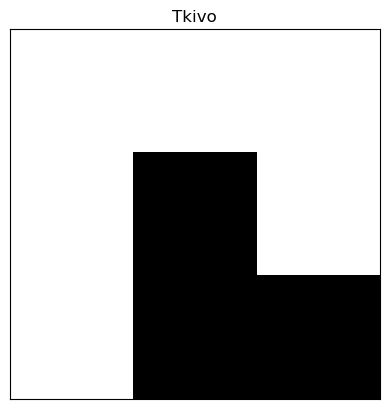

In [47]:
# test the class
tissue_matrix_5by5 = np.array([[0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0],   
                           [0, 1, 1, 1, 0],
                           [0, 1, 1, 0, 0],
                           [0, 0, 0, 0, 0]])

tissue_matrix_3by3 = np.array([[0, 0, 0,],
                           [0, 1, 0],
                           [0,1,1]])

tissue_matrix_2by2 =  np.array([[0, 0],
                               [1, 0]])

tissue_matrix = tissue_matrix_3by3  # choose one of the matrices above


# upscale matrix
upscale_factor = 1
tissue_matrix = upscale_matrix(tissue_matrix, upscale_factor)

# parameters
MinDoseTumor = 100  # minimum dose to tumor cells
MaxDoseHealthy = None # maximum dose to healthy cells (optional, can be None)
cell_dose_constr = {
    'min_dose_tumor': MinDoseTumor,
    'max_dose_healthy': MaxDoseHealthy
}
mean_free_path = 1 * upscale_factor # mfp in terms of cells, eg 2 cells, multiply by uscale_factor if supcaled matrix
lac = 1.0 / mean_free_path  # linear attenuation coefficient in 1/cell
SIF = None

##### choose beam type
beam_type = ['constant','exponential','simulated'][1]  # choose beam type: 'constant', 'exponential', or 'simulated'
print(f"---------------Beam type chosen: {beam_type}-------------------")
if beam_type == 'simulated':
    tissue_dimension_simulated = SIF_expanded.shape[0] // 4  # number of rows or columns in the simulated tissue matrix
    if tissue_dimension_simulated == tissue_matrix.shape[0]:
        print("Tissue shape for 'simulated' beam type is correct.")
    else:
        raise ValueError(f"Tissue shape for 'simulated' beam type should be {tissue_dimension_simulated}x{tissue_dimension_simulated}, but got {tissue_matrix.shape[0]}x{tissue_matrix.shape[1]}.")



# create a problem instance
problem = TissueIrradiationProblem(tissue_matrix)
# plot the tissue matrix
problem.plot_tissue()



In [48]:
# prepare data for linear programming
ProblemParameters = problem.prepare_data_for_linprog(cell_dose_constr, beam_type=beam_type, lac=lac, sim_irr_factors=SIF_expanded)

#ProblemParameters


Using exponential intensity beam model with linear attenuation coefficient (lac): 1.0 /cm


optimization time

In [49]:
# optimize class
optimizer = TissueIrradiationOptimizer(ProblemParameters)
# run optimization
report = [False, True] [1]
optimizer.optimize(doReport=report)

# calculate dose distribution
TissueDoseDistribution = optimizer.tissue_dose_matrix

print("\nDose Distribution Matrix:")
print(TissueDoseDistribution)


Optimization successful.
Optimal value: 50.32147244080551
Optimal solution: [  0.           0.           0.           0.           0.
 100.           0.           0.           0.           0.
 271.82818285   0.        ]

Dose Distribution Matrix:
[[  0.          36.78794412   0.        ]
 [  0.         100.           0.        ]
 [ 13.53352832 308.61612696 100.        ]]


plot and statistics

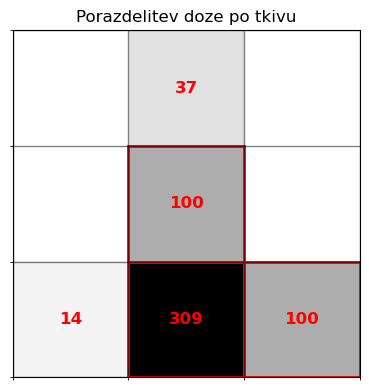

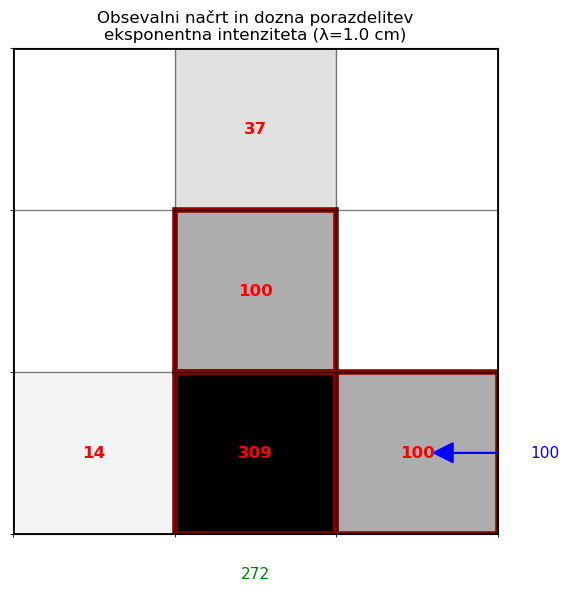

Statistics:
Average dose to tumor cells: 169.54
Average dose to healthy cells: 8.39


In [50]:
optimizer.plot_dose_distribution()
optimizer.plot_irradiation_scheme()
# calculate statistics
optimizer.report_statistics()

----------

Finish

---------------
-----------------
